In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /root/.ssh/
!cp /content/drive/Shareddrives/CSCI\ 567:\ ML/deploy_keys/id_ed25519* /root/.ssh
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!ssh -T git@github.com

# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
Hi rogue-agents-sc/rogue-gym! You've successfully authenticated, but GitHub does not provide shell access.


In [4]:
!pip install /content/drive/Shareddrives/CSCI\ 567:\ ML/rogue-gym/rogue_gym-0.0.2-cp310-cp310-linux_x86_64.whl

Processing ./drive/Shareddrives/CSCI 567: ML/rogue-gym/rogue_gym-0.0.2-cp310-cp310-linux_x86_64.whl


In [37]:
def process_strings_to_matrix(string_list):
    max_length = max(len(s) for s in string_list)
    matrix = [[' ' for _ in range(max_length)] for _ in range(len(string_list))]

    for i, s in enumerate(string_list):
        for j, char in enumerate(s):
            matrix[i][j] = char

    return matrix

In [38]:
def is_player_in_dungeon(matrix, player_symbol= '@'):
    dungeon_boundaries = []
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == '-' or element == '|':
                dungeon_boundaries.append((i, j))


    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == player_symbol:
                if not any(start_i <= i <= end_i and start_j <= j <= end_j for (start_i, start_j) in dungeon_boundaries for (end_i, end_j) in dungeon_boundaries):
                    return False
                break

    return True

In [39]:
def is_player_near_gold(matrix, player_symbol = '@', gold_symbol = '*'):
    dungeon_boundaries = []
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == '-' or element == '|':
                dungeon_boundaries.append((i, j))

    player_found = False
    gold_found = False
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == player_symbol:
                player_found = True
            elif element == gold_symbol:
                gold_found = True

            if player_found and gold_found:
                break

    return player_found and gold_found

In [40]:
def is_player_near_downstairs(matrix, player_symbol = '@', gold_symbol = '%'):
    dungeon_boundaries = []
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == '-' or element == '|':
                dungeon_boundaries.append((i, j))

    player_found = False
    gold_found = False
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == player_symbol:
                player_found = True
            elif element == gold_symbol:
                gold_found = True

            if player_found and gold_found:
                break

    return player_found and gold_found

In [41]:
def find_player_dungeon(matrix, player_symbol,player_i, player_j):
    dungeon_boundaries = []
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == '-' or element == '|':
                dungeon_boundaries.append((i, j))

    for start_i, start_j in dungeon_boundaries:
        end_i, end_j = dungeon_boundaries[-1]
        if start_i <= player_i <= end_i and start_j <= player_j <= end_j:
            return start_i, start_j, end_i, end_j

def doors_within_dungeon(result_matrix, player_symbol = '@', door_symbol = '+'):
  player_i, player_j = None, None
  for i, row in enumerate(result_matrix):
      for j, element in enumerate(row):
          if element == player_symbol:
              player_i, player_j = i, j
              break

  player_dungeon_boundaries = find_player_dungeon(result_matrix, player_symbol,player_i, player_j)
  if player_dungeon_boundaries is not None:
      start_i, start_j, end_i, end_j = player_dungeon_boundaries
      for i in range(start_i, end_i + 1):
          if result_matrix[i][start_j] == door_symbol or result_matrix[i][end_j] == door_symbol:
              return True

      for j in range(start_j, end_j + 1):
          if result_matrix[start_i][j] == door_symbol or result_matrix[end_i][j] == door_symbol:
              return True

  return False

In [42]:
def q_value_approximation(result_matrix, weights, player_location,downstairs_location, new_level):
    in_dungeon = 1 if is_player_in_dungeon(result_matrix) else 0
    in_passage = 0 if in_dungeon == 1 else 1
    door_pathway_present = 1 if doors_within_dungeon(result_matrix) else 0
    downstairs_present = 1 if is_player_near_downstairs(result_matrix) else 0
    on_downstairs_symbol = 1 if player_location == downstairs_location else 0
    gold_present = 1 if is_player_near_gold(result_matrix) else 0
    new_level = 1 if True else 0


    q_value = (
        weights['in_dungeon'] * in_dungeon +
        weights['in_passage'] * in_passage +
        weights['door_pathway_present'] * door_pathway_present +
        weights['downstairs_present'] * downstairs_present +
        weights['on_downstairs_symbol'] * on_downstairs_symbol +
        weights['gold_present'] * gold_present +
        weights['new_level'] * new_level
    )

    return q_value

def initialize_weights(binary_features):
    return {feature: random.uniform(0, 1) for feature in binary_features}

In [43]:
def egreedy_selection(grades,epsilon):
  if random.randint(1,100) <= epsilon:
    state = random.choice(grades)
    return state
  else:
    max_grade = max(grades, key=lambda x: x[1])[1]
    states_check = [state for state, grade in grades if grade == max_grade]
    state = random.choice(states_check)

  return (state,max_grade)

In [44]:
def calculate_td_error(reward,predicted_q,next_q, discount):
  return reward + (next_q * discount) - predicted_q

In [45]:
def update_weights(weights, td_error, learning_rate):
    updated_weights = {}

    for feature, weight in weights.items():
        updated_weight = weight + learning_rate * td_error
        updated_weights[feature] = updated_weight

    return updated_weights


In [46]:
def find_symbol_numpy(matrix, symbol):
    matrix_np = np.array(matrix)
    indices = np.where(matrix_np == symbol)
    if len(indices[0]) > 0:
        return list(zip(indices[0], indices[1]))[0]
    else:
        return None

In [47]:
class Node:
    def __init__(self, state, reward, done, previous_moves, parent=None, action_to_reach=None):
        self.state = state
        self.reward = reward
        self.done = done
        self.previous_moves = previous_moves
        self.children = []
        self.visits = 0
        self.value = 0
        self.parent = parent
        self.action_to_reach = action_to_reach

    def add_child(self, child):
        child.parent = self
        self.children.append(child)

def UCT(node):
    return node.value / node.visits + np.sqrt(2 * np.log(node.parent.visits) / node.visits)

def select(node):
    if not node.children:
        return node
    else:
        return max(node.children, key=UCT)

def expand(node, env):
    for action in env.ACTIONS:
        if action == '.':
          continue
        env = RogueEnv(max_steps=1000000000000, config_dict=CONFIG)
        env.reset()
        for move in node.previous_moves:
            env.step(move)
        state, reward, done, _ = env.step(action)
        child = Node(state, reward, done, node.previous_moves + [action], node, action)
        node.add_child(child)

def simulate(node, env, num_rounds=15):
    for _ in range(num_rounds):
        filtered_actions = [action for action in env.ACTIONS if action != '.']
        action = np.random.choice(filtered_actions)

        state, reward, done, _ = env.step(action)
        node = Node(state, reward, done, node.previous_moves + [action], node.parent, action)
        if done:
            break
    return node.reward

def backpropagate(node, reward):
    node.visits += 1
    node.value += reward
    if node.parent is not None:
        backpropagate(node.parent, reward)

def MCTS(root, env, iterations):
    for _ in range(iterations):
        node = select(root)

        expand(node, env)

        for child in node.children:
            reward = simulate(child, env)
            backpropagate(child, reward)
    return max(root.children, key=lambda node: node.value / node.visits).action_to_reach

In [48]:
def get_most_promising_path(root):
    node = root
    path = []
    while node.children:
        best_child = max(node.children, key=lambda child: child.value / child.visits)
        path.append(best_child.action_to_reach)
        node = best_child
    return path

In [52]:
from rogue_gym.envs import RogueEnv
import numpy as np
import random

CONFIG = {
    "width": 32,
    "height": 16,
    "seed": 1,
    "hide_dungeon": True,
    "dungeon": {
        "style": "rogue",
        "room_num_x": 2,
        "room_num_y": 2,
    },
    "enemies": {
        "enemies": [],
    },
}

env = RogueEnv(max_steps=1000000000000, config_dict=CONFIG)
state = env.reset()

total_reward_list = []
result_matrix = process_strings_to_matrix(state.dungeon)

binary_features = ['in_dungeon', 'in_passage', 'door_pathway_present', 'downstairs_present', 'on_downstairs_symbol', 'gold_present','new_level']
epsilon = 10
learning_rate = 0.4
discount = 0.4


weights = initialize_weights(binary_features)

for episode in range(100):
  seed = random.randint(0,40)
  CONFIG["seed"] = seed
  env = RogueEnv(max_steps=1000000000000, config_dict=CONFIG)
  state = env.reset()
  previous_moves = []
  rewards = 0

  for x in range(0,100,2):
    q_value_scores = []
    result_matrix = process_strings_to_matrix(state.dungeon)
    player_location = find_symbol_numpy(result_matrix,'@')
    downstairs_location = find_symbol_numpy(result_matrix,'%')
    current_level = state.status['dungeon_level']
    new_level = False

    if x == 98:
      #get the q value for each move

      #move right up
      state,reward,done,_ = env.step('u')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('u',score))
      state,reward,done,_ = env.step('b')

      #move left down
      state,reward,done,_ = env.step('b')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('b',score))
      state,reward,done,_ = env.step('u')

      #move down
      state,reward,done,_ = env.step('j')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('j',score))
      state,reward,done,_ = env.step('k')

      #move up
      state,reward,done,_ = env.step('k')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('k',score))
      state,reward,done,_ = env.step('j')

      #move left
      state,reward,done,_ = env.step('h')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('h',score))
      state,reward,done,_ = env.step('l')

      #move right
      state,reward,done,_ = env.step('l')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('l',score))
      state,reward,done,_ = env.step('h')

      #move left up
      state,reward,done,_ = env.step('y')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('y',score))
      state,reward,done,_ = env.step('n')

      #move right down
      state,reward,done,_ = env.step('n')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('n',score))
      state,reward,done,_ = env.step('y')

      #search
      state,reward,done,_ = env.step('s')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('s',score))

      #no operation
      #state,reward,done,_ = env.step('s')
      #result_matrix = process_strings_to_matrix(state.dungeon)
      #score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      #q_value_scores.append(('s',score))

      #downstairs
      current_level = state.status['dungeon_level']
      state,reward,done,_ = env.step('>')
      result_matrix = process_strings_to_matrix(state.dungeon)
      if current_level != state.status['dungeon_level']:
        new_level = True
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('>',score))
      if current_level != state.status['dungeon_level']:
        env = RogueEnv(max_steps=1000000000000, config_dict=CONFIG)
        state = env.reset()
        if len(previous_moves) > 0:
          for x in previous_moves:
            state,reward,done,_ = env.step(x)

      #do greedy selection to figure out next move and q value score for current state
      desired_tuple = egreedy_selection(q_value_scores,epsilon)
      desired_action = desired_tuple[0]
      predicted_q_value_score = desired_tuple[1]

      #update environment
      state,reward,done,_ = env.step(desired_action)
      previous_moves.append(desired_action)
      if rewards < reward:
        rewards = reward

      #feed into MCTS
      root = Node(state,reward,done,previous_moves)
      next_action = MCTS(root,env,20)

      #update state based on MCTS best action
      state,reward,done,_ = env.step(next_action)
      previous_moves.append(next_action)
      if rewards < reward:
        rewards = reward
      #update weights
      result_matrix = process_strings_to_matrix(state.dungeon)
      if current_level != state.status['dungeon_level']:
        new_level = True
      else:
        new_level = False
      max_predicted_q_score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)

      td_error = calculate_td_error(reward,predicted_q_value_score,max_predicted_q_score, discount)
      weights = update_weights(weights, td_error, learning_rate)
      total_reward_list.append(rewards)

    else:

      #get the q value for each move

      #move right up
      state,reward,done,_ = env.step('u')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('u',score))
      state,reward,done,_ = env.step('b')

      #move left down
      state,reward,done,_ = env.step('b')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('b',score))
      state,reward,done,_ = env.step('u')

      #move down
      state,reward,done,_ = env.step('j')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('j',score))
      state,reward,done,_ = env.step('k')

      #move up
      state,reward,done,_ = env.step('k')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('k',score))
      state,reward,done,_ = env.step('j')

      #move left
      state,reward,done,_ = env.step('h')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('h',score))
      state,reward,done,_ = env.step('l')

      #move right
      state,reward,done,_ = env.step('l')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('l',score))
      state,reward,done,_ = env.step('h')

      #move left up
      state,reward,done,_ = env.step('y')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('y',score))
      state,reward,done,_ = env.step('n')

      #move right down
      state,reward,done,_ = env.step('n')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('n',score))
      state,reward,done,_ = env.step('y')

      #search
      state,reward,done,_ = env.step('s')
      result_matrix = process_strings_to_matrix(state.dungeon)
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('s',score))

      #no operation
      #state,reward,done,_ = env.step('s')
      #result_matrix = process_strings_to_matrix(state.dungeon)
      #score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      #q_value_scores.append(('s',score))

      #downstairs
      current_level = state.status['dungeon_level']
      state,reward,done,_ = env.step('>')
      result_matrix = process_strings_to_matrix(state.dungeon)
      if current_level != state.status['dungeon_level']:
        new_level = True
      score = q_value_approximation(result_matrix,weights,player_location,downstairs_location,new_level)
      q_value_scores.append(('>',score))
      if current_level != state.status['dungeon_level']:
        env = RogueEnv(max_steps=1000000000000, config_dict=CONFIG)
        state = env.reset()
        if len(previous_moves) > 0:
          for x in previous_moves:
            state,reward,done,_ = env.step(x)

      #do greedy selection to figure out next move
      desired_tuple = egreedy_selection(q_value_scores,epsilon)
      desired_action = desired_tuple[0]

      #update environment
      state,reward,done,_ = env.step(desired_action)
      previous_moves.append(desired_action)

      if rewards < reward:
        rewards = reward

      #feed into MCTS
      root = Node(state,reward,done,previous_moves)
      next_action = MCTS(root,env,20)

      env = RogueEnv(max_steps=1000000000000, config_dict=CONFIG)
      state = env.reset()
      if len(previous_moves) > 0:
        for x in previous_moves:
          state,reward,done,_ = env.step(x)

      #update state based on MCTS best action
      state,reward,done,_ = env.step(next_action)

      previous_moves.append(next_action)
      if rewards < reward:
        rewards = reward


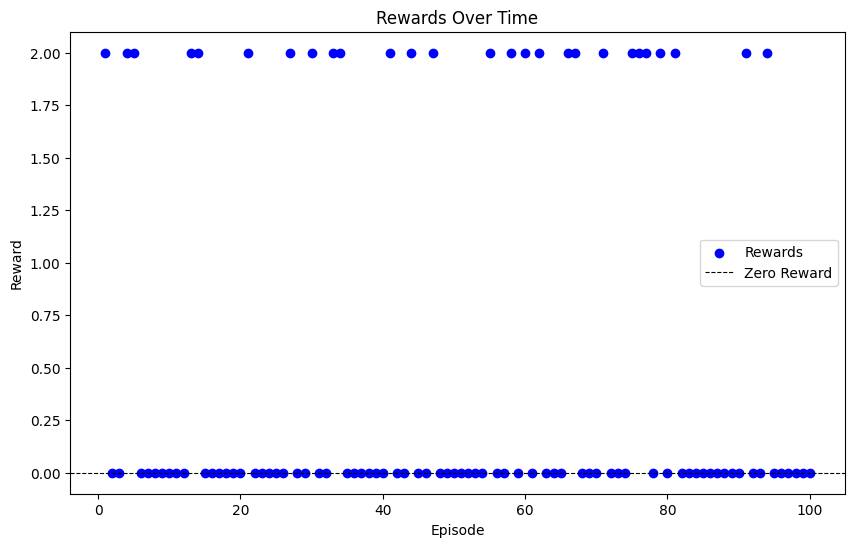

In [53]:
import matplotlib.pyplot as plt

episodes = list(range(1, len(total_reward_list) + 1))

plt.figure(figsize=(10, 6))
plt.scatter(episodes, total_reward_list, marker='o', color='b', label='Rewards')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Reward')

plt.title('Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.legend()
plt.show()